# 
<a id="data-prep"></a>
<div style="background-color: #000D5B; color: white; text-align: center; padding: 6px 0 22px 0">
    <h3 style="background-color: #000D5B; color: white; text-align: left">RMIT School of Computer Science and Technology</h3>
    <br/>
    <h1>COSC3007: Deep Learning</h1>
    <h2>Assignment 2: Stance Twitter Sentiment Analysis and Detection </h2>
    <h2> [2] MODELLING AND MODEL EVALUATIONS </h2>

</div>

# Import Libs

In [1]:
import pandas as pd 
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np 

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder

import numpy as np

# [1] Load Data

In [2]:
train_df = pd.read_csv("./StanceDataset/processed_train.csv", encoding = "ISO-8859-1", engine="python").drop(columns=['Unnamed: 0'])
test_df = pd.read_csv("./StanceDataset/processed_test.csv", encoding = "ISO-8859-1", engine="python").drop(columns=['Unnamed: 0'])

# [2] Prepare label and fit data

## Split test and val

In [3]:
test_df, val_df = train_test_split(test_df, test_size=0.5, random_state=42)

## Tweets

In [4]:
# Load GloVe embeddings
embedding_dim = 100  # This should match the GloVe
glove_dir = 'path_to_glove' 

embeddings_index = {}
with open("./glove.6B.100d.txt", encoding='utf8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs

In [5]:

# Initialize and fit the tokenizer on the training data
tokenizer = Tokenizer()
tokenizer.fit_on_texts(train_df['processed_tweet'])

# Convert texts to sequences for all datasets
train_sequences = tokenizer.texts_to_sequences(train_df['processed_tweet'])
test_sequences = tokenizer.texts_to_sequences(test_df['processed_tweet'])
val_sequences = tokenizer.texts_to_sequences(val_df['processed_tweet'])

MAX_LENGTH = max(
    max(len(seq) for seq in train_sequences), 
    max(len(seq) for seq in val_sequences), 
    max(len(seq) for seq in test_sequences)
)

# Pad the sequences
train_pad = pad_sequences(train_sequences, maxlen=MAX_LENGTH, padding='post')
test_pad = pad_sequences(test_sequences, maxlen=MAX_LENGTH, padding='post')
val_pad = pad_sequences(val_sequences, maxlen=MAX_LENGTH, padding='post')

# Extract the word index and vocab size
word_index = tokenizer.word_index
print("Unique tokens: " + str(len(word_index)))
vocab_size = len(word_index) + 1
print('Vocab size: ' + str(vocab_size))

# Create an embedding matrix
embedding_matrix = np.zeros((vocab_size, embedding_dim))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector


Unique tokens: 6256
Vocab size: 6257


## Stances

In [6]:
def categorized_label(df, label_name):
    label_encoder = LabelEncoder()
    encoded_labels = label_encoder.fit_transform(df[label_name])
    categorical_labels = to_categorical(encoded_labels)
    return categorical_labels

In [7]:
train_labels = categorized_label(train_df, "Stance")
test_labels = categorized_label(test_df, "Stance")
val_labels = categorized_label(val_df, "Stance")

# [3] Create Model

In [8]:
from keras import backend as K
from tensorflow.keras.optimizers.legacy import Adam
from hyperopt import hp
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials
import keras_tuner as kt

In [9]:
# Define the F1 score metric
def f1_score(y_true, y_pred):
    # Calculate Precision and Recall
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    
    # Calculate F1 score
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

Set up call backs and learning rates

In [10]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint


# Define the EarlyStopping and ReduceLROnPlateau callbacks
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=50,
    verbose=1,
    restore_best_weights=True,
)

lr_scheduler = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=5,
    min_lr=1e-5,
    verbose=1,
)

# Define the ModelCheckpoint callback
checkpoint_path = "best_model2.h5"
model_checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_path,
    save_best_only=True,    # Only save a model if 'val_loss' has improved
    monitor='val_loss',     # Monitor 'val_loss' during training
    mode='min',             # The model is saved when 'val_loss' is minimized
    verbose=1)

# Combine all callbacks in a list
callbacks = [
    early_stopping,
    # lr_scheduler,
    model_checkpoint_callback
]

learning_rate = 0.001
optimizer = Adam(learning_rate=learning_rate)

Set up keras tuner

In [11]:
space = {
    'units1': hp.choice('units1', [64, 128, 256]),
    'units2': hp.choice('units2', [64, 128, 256]),
    'dropout1': hp.uniform('dropout1', 0, 0.5),
    'dropout2': hp.uniform('dropout2', 0, 0.5),
    'recurrent_dropout1': hp.uniform('recurrent_dropout1', 0, 0.5),
    'recurrent_dropout2': hp.uniform('recurrent_dropout2', 0, 0.5),
    'l2_reg': hp.uniform('l2_reg', 0.0001, 0.01),
    'l2_reg2': hp.uniform('l2_reg2', 0.0001, 0.01),
    'l2_reg3': hp.uniform('l2_reg3', 0.0001, 0.01),
    'l2_reg4': hp.uniform('l2_reg34', 0.0001, 0.01),
    'learning_rate': hp.loguniform('learning_rate', np.log(0.0001), np.log(0.01)),
    'batch_size': hp.choice('batch_size', [32, 64, 128])
}

In [12]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, BatchNormalization, Bidirectional, Flatten
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers.legacy import Adam
import keras_tuner as kt

def build_model(hp):
    model = Sequential()
    model.add(Embedding(vocab_size, embedding_dim, weights=[embedding_matrix], input_length=MAX_LENGTH, trainable=False))

    # Tuning the number of units in the first biLSTM layer
    model.add(Bidirectional(LSTM(units=hp.Int('units1', min_value=32, max_value=1024, step=32),
                   return_sequences=True, 
                   dropout=hp.Float('dropout1', min_value=0, max_value=0.8, step=0.1),
                   recurrent_dropout=hp.Float('recurrent_dropout1', min_value=0, max_value=0.5, step=0.1),
                   kernel_regularizer=l2(hp.Float('l2_reg1', min_value=0.0001, max_value=0.01, sampling='LOG')))))
    
    # # Tunable dropout rate for the first layer
    # dropout_rate_1 = hp.Float('dropout_layer_1', min_value=0.0, max_value=0.5, step=0.1)
    # model.add(Dropout(dropout_rate_1))
    
    # Tuning the number of units in the second biLSTM layer
    model.add(Bidirectional(LSTM(units=hp.Int('units2', min_value=32, max_value=1024, step=32),
                   dropout=hp.Float('dropout2', min_value=0, max_value=0.8, step=0.1),
                   recurrent_dropout=hp.Float('recurrent_dropout2', min_value=0, max_value=0.5, step=0.1),
                   kernel_regularizer=l2(hp.Float('l2_reg2', min_value=0.0001, max_value=0.01, sampling='LOG')))))

    # Tunable dropout rate for the second layer
    dropout_rate_2 = hp.Float('dropout_layer_2', min_value=0.0, max_value=0.8, step=0.1)
    model.add(Dropout(dropout_rate_2))
    
    # Dense layer with tunable units
    model.add(Dense(
        units=hp.Int('dense_layer_units_1', min_value=32, max_value=512, step=32),
        activation="relu",
        kernel_regularizer=l2(hp.Float('dense_l2_reg', min_value=0.0001, max_value=0.005, sampling='LOG'))
    ))

    # Tunable dropout rate for the second layer
    dropout_rate_3 = hp.Float('dropout__layer_3', min_value=0.0, max_value=0.8, step=0.1)
    model.add(Dropout(dropout_rate_3))
    
    # Final Layer
    model.add(Dense(3, activation='softmax'))

    # Tuning the learning rate for the optimizer
    model.compile(optimizer=Adam(hp.Float('learning_rate', min_value=1e-5, max_value=1e-2, sampling='LOG')),
                  loss='categorical_crossentropy', 
                  metrics=['categorical_accuracy', f1_score])

    return model


In [13]:
best_model = None
best_hps = None

# Hyperparameter tuning configuration
objective = kt.Objective("f1_score", direction="max")
tuning_config = {
    'objective': objective,
    'max_epochs': 30,
    'directory': 'keras_tuner_dir',
    'project_name': 'lstm_stance_classification'
}

# Early stopping callback
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

batch_sizes = [32, 64, 128]
batch_size = 32
best_batch_size = None
best_val_accuracy = -1

# for batch_size in batch_sizes:
print(f"Trying batch size: {batch_size}")

# Initialize the tuner
tuner = kt.Hyperband(build_model, **tuning_config)

# Search for the best hyperparameters
tuner.search(train_pad, train_labels, 
            epochs=50, 
            validation_data=(val_pad, val_labels), 
            callbacks=[stop_early],
            batch_size=batch_size)

best_model = tuner.get_best_models(num_models=1)[0]
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
best_model.save('best_model.h5')

Trial 15 Complete [00h 13m 18s]
f1_score: 0.36640986800193787

Best f1_score So Far: 0.3825816810131073
Total elapsed time: 02h 29m 11s

Search: Running Trial #16

Value             |Best Value So Far |Hyperparameter
416               |768               |units1
0.8               |0.2               |dropout1
0.1               |0.2               |recurrent_dropout1
0.0033907         |0.0030956         |l2_reg1
224               |352               |units2
0.4               |0.3               |dropout2
0.2               |0                 |recurrent_dropout2
0.0057519         |0.0020428         |l2_reg2
0.4               |0.8               |dropout_layer_2
256               |192               |dense_layer_units_1
0.00074318        |0.0034316         |dense_l2_reg
0.7               |0.5               |dropout__layer_3
1.0487e-05        |0.00057615        |learning_rate
2                 |2                 |tuner/epochs
0                 |0                 |tuner/initial_epoch
3             

2023-12-23 14:10:10.695255: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


92/92 [==============================] - ETA: 0s - loss: 12.3722 - categorical_accuracy: 0.3617 - f1_score: 0.1187

2023-12-23 14:17:56.196478: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


92/92 [==============================] - 486s 5s/step - loss: 12.3722 - categorical_accuracy: 0.3617 - f1_score: 0.1187 - val_loss: 12.1416 - val_categorical_accuracy: 0.4141 - val_f1_score: 0.0000e+00
Epoch 2/2
 7/92 [=>............................] - ETA: 7:45 - loss: 12.1070 - categorical_accuracy: 0.3973 - f1_score: 0.1571

In [ ]:
best_model2 = tuner.get_best_models(num_models=1)[0]
z = best_model2.evaluate(test_pad, test_labels)
print('Test accuracy:', z)

2023-12-22 20:06:16.539862: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


31/31 [==============================] - 15s 405ms/step - loss: 1.1385 - accuracy: 0.5501 - f1_score: 0.3631
Test accuracy: [1.1385471820831299, 0.5501022338867188, 0.3631410598754883]


Recreate the best model with more training time

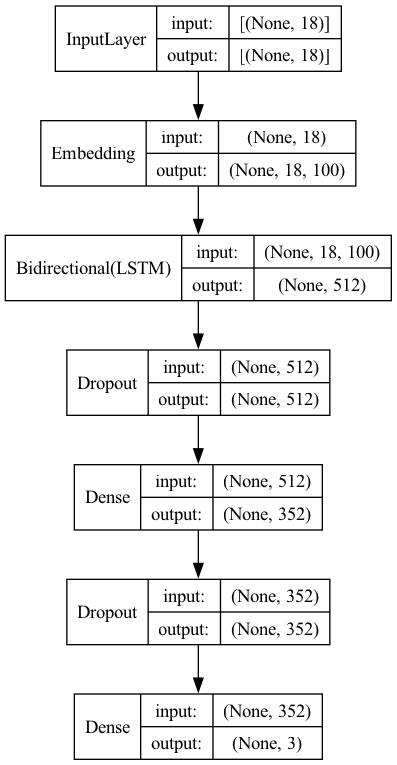

In [ ]:
from tensorflow.keras.utils import plot_model
model = build_model(tuner.get_best_hyperparameters(num_trials=1)[0])
plot_model(model, show_layer_names=False, show_shapes=True, to_file='model.png')

In [ ]:
history = model.fit(train_pad, train_labels, 
                    epochs=30, 
                    validation_data=(val_pad, val_labels), 
                    batch_size=best_batch_size, 
                    callbacks=callbacks,
                    shuffle = True)

Epoch 1/30


2023-12-22 20:15:58.955533: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


92/92 [==============================] - ETA: 0s - loss: 1.2323 - accuracy: 0.4647 - f1_score: 0.1615

2023-12-22 20:18:53.393274: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


92/92 [==============================] - 191s 2s/step - loss: 1.2323 - accuracy: 0.4647 - f1_score: 0.1615 - val_loss: 1.1911 - val_accuracy: 0.5143 - val_f1_score: 0.3936 - lr: 2.9869e-05
Epoch 2/30
92/92 [==============================] - 171s 2s/step - loss: 1.2005 - accuracy: 0.4863 - f1_score: 0.3008 - val_loss: 1.1758 - val_accuracy: 0.5245 - val_f1_score: 0.3235 - lr: 2.9869e-05
Epoch 3/30
92/92 [==============================] - 170s 2s/step - loss: 1.1726 - accuracy: 0.5106 - f1_score: 0.3281 - val_loss: 1.1602 - val_accuracy: 0.5481 - val_f1_score: 0.3312 - lr: 2.9869e-05
Epoch 4/30
92/92 [==============================] - 190s 2s/step - loss: 1.1471 - accuracy: 0.5367 - f1_score: 0.3628 - val_loss: 1.1514 - val_accuracy: 0.5562 - val_f1_score: 0.3452 - lr: 2.9869e-05
Epoch 5/30
92/92 [==============================] - 187s 2s/step - loss: 1.1237 - accuracy: 0.5456 - f1_score: 0.3900 - val_loss: 1.1439 - val_accuracy: 0.5501 - val_f1_score: 0.3618 - lr: 2.9869e-05
Epoch 6/30


KeyboardInterrupt: 